In [1]:
# BEWARE
# The dataset used here is not public, so you will not be able to rerun the notebook.

# The dataset used here is ERA5 global historical reanalysis, surface air temperature
# Other variables readily accessible are wind speed at 10m, relative humidity, dew point temperature, precipitation

# Please contact alessio.arena@csiro.au if you would like other analysis or visualisation of data

In [2]:
import sys
sys.path.extend(['../../xarray_utilities/', '../../nbic-workflow/'])

import xarray as xr
import nbic_utils as nbic
import xrutils as xru
import pandas as pd
import dask

import numpy as np
import matplotlib.pyplot as plt

/home/jovyan/ohw23_proj_SAupwelling/Notebooks/../../xarray_utilities/xrutils/geo.py:13: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as _gpd


In [3]:
client, cluster = nbic.easi_cluster()

cluster

Uploading wheel /home/jovyan/nbic-workflow/dist/nbic_utils-0.1.0-py3-none-any.whl
Requesting for workers to install ['/home/jovyan/nbic-workflow/dist/nbic_utils-0.1.0-py3-none-any.whl']


In [4]:
client

<Client: 'tls://10.0.51.198:8786' processes=4 threads=32, memory=128.00 GiB>

In [5]:
v10 = xr.open_zarr('s3://nbic1-stage-shared-artifacts/ERA5/v10/AU_v10.zarr').v10
u10 = xr.open_zarr('s3://nbic1-stage-shared-artifacts/ERA5/u10/AU_u10.zarr').u10

u10

<xarray.DataArray 'u10' (time: 368928, latitude: 145, longitude: 193)>
dask.array<open_dataset-926b4c54a1bed5d54fbadf646768176bu10, shape=(368928, 145, 193), dtype=float32, chunksize=(5000, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -9.0 -9.25 -9.5 -9.75 ... -44.5 -44.75 -45.0
  * longitude  (longitude) float32 110.0 110.2 110.5 110.8 ... 157.5 157.8 158.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-01-31T23:00:00
Attributes:
    long_name:  10 metre U wind component
    units:      m s**-1

In [6]:
# calculate the daily maximum temperature
# daily_max_u10 = u10.resample({'time':'1D'}).max()
# daily_max_u10

In [7]:
# monthly_idx = daily_max_temp.time.dt.strftime('%Y-%m')
# monthly_idx.name = 'months'
# monthly_idx

In [8]:
monthly_average_u10 = u10.resample({'time':'1m'}).mean()
monthly_average_v10 = v10.resample({'time':'1m'}).mean()


monthly_average_u10

<xarray.DataArray 'u10' (time: 505, latitude: 145, longitude: 193)>
dask.array<stack, shape=(505, 145, 193), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -9.0 -9.25 -9.5 -9.75 ... -44.5 -44.75 -45.0
  * longitude  (longitude) float32 110.0 110.2 110.5 110.8 ... 157.5 157.8 158.0
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2021-01-31
Attributes:
    long_name:  10 metre U wind component
    units:      m s**-1

In [9]:
monthly_average_u10 = monthly_average_u10.coarsen(dict(latitude=2, longitude=2), boundary='pad').mean()
monthly_average_v10 = monthly_average_v10.coarsen(dict(latitude=2, longitude=2), boundary='pad').mean()

In [10]:
monthly_average_u10, monthly_average_v10 = dask.persist(monthly_average_u10, monthly_average_v10)

In [11]:
# yearly_average_of_daily_max = u10.resample({'time':'1Y'}).mean()
# yearly_average_of_daily_max

In [12]:
# yearly_average_of_daily_max = yearly_average_of_daily_max.persist()
# yearly_average_of_daily_max

In [13]:
# fig = xru.geo.subplots_with_outline(
#     yearly_average_of_daily_max.sel(time=slice('2011-12-31', '2016-12-31'), latitude=slice(-25, -40), longitude=slice(130, 145)), 
#     col='time', 
#     ncols=3, 
#     crs=4326,
#     cmap='PiYG',
#     # plot_kwargs={'levels':[-3, -2, -1, 0, 1, 2, 3]}
# )

In [14]:
monthly_average_uv10 = xr.combine_by_coords([monthly_average_u10, monthly_average_v10])
monthly_average_uv10

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 97, time: 505)
Coordinates:
  * latitude   (latitude) float32 -9.125 -9.625 -10.12 ... -44.12 -44.62 -45.0
  * longitude  (longitude) float32 110.1 110.6 111.1 111.6 ... 157.1 157.6 158.0
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2021-01-31
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>

/env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/env/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes

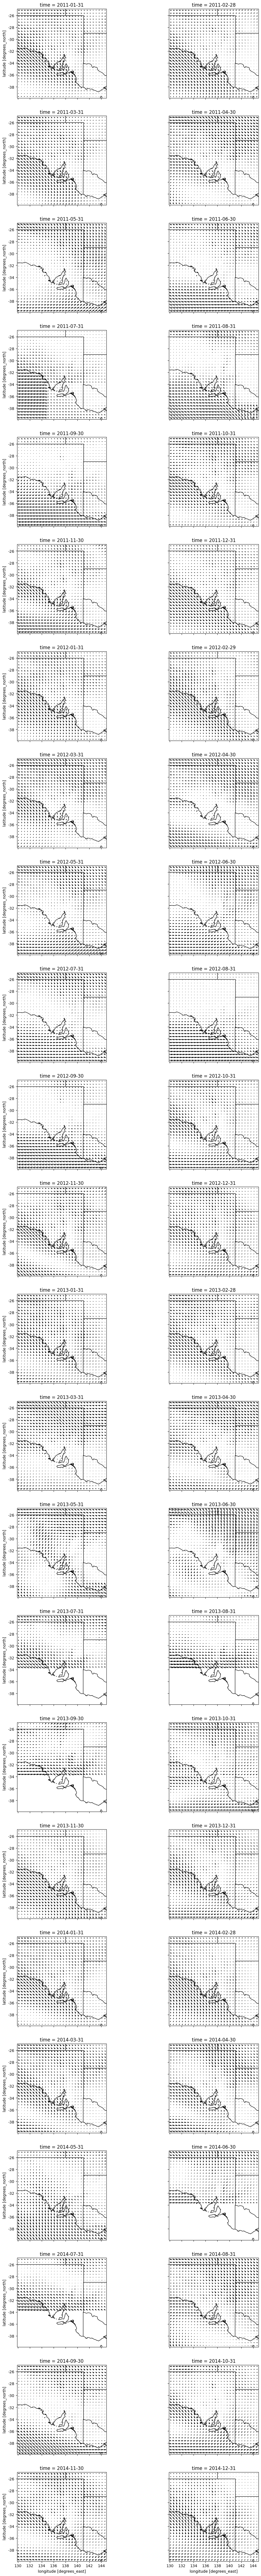

In [15]:
fig = xru.geo.subplots_with_outline(
    monthly_average_uv10.sel(time=slice('2011-01-01', '2014-12-31'), latitude=slice(-25, -40), longitude=slice(130, 145)), 
    col='time', 
    ncols=2, 
    crs=4326,
    cmap='PiYG',
    plot_method='quiver',
    plot_kwargs={'u':'u10', 'v':'v10', 'x':'longitude', 'y':'latitude', 'headwidth':3, 'headlength':5, 'width':0.005}
)